# ECE 570 Assignment 6 Exercise






Your Name: Mohmmad Alwakeel

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [2]:
# Import and load MNIST data
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################

    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
          
    def __call__(self, tensor):
        tn_size = tensor.size()
        image_noise = tensor + self.mean+ torch.randn(tn_size) * self.std 
        y = torch.clamp(image_noise,min=0,max = 1)
        return y

    

  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.0
0.0


In [3]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')
print(f'Device name {torch.cuda.get_device_name(0)}')

We are using device name "cuda"
Device name NVIDIA GeForce GTX 1060 with Max-Q Design


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


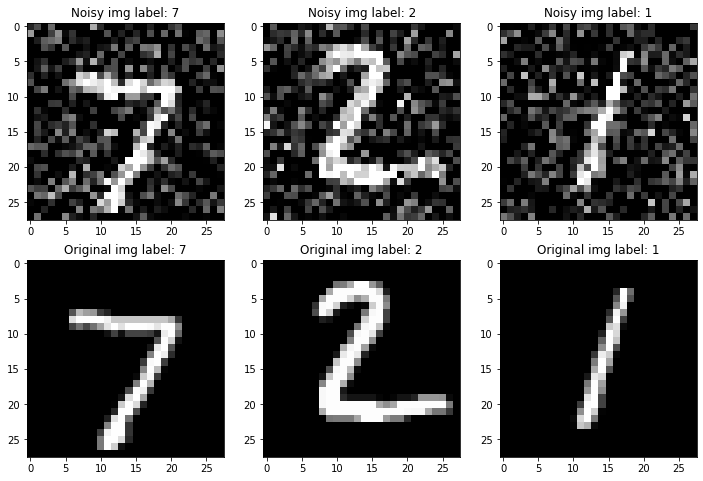

In [353]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)
###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 


batch_idx, (images, _) = next(enumerate(test_loader))
#images = images.to(device).cpu().detach()
#images = images.cpu()

#print(images.size(), output.size())

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)

for idx in range(3):
    ax[0,idx].imshow(images[0][idx][0], cmap='gray')
    ax[0,idx].set_title(f'Noisy img label: {images[1][idx]}')
    ax[1,idx].imshow(_[0][idx][0], cmap='gray')
    ax[1,idx].set_title(f'Original img label: {_[1][idx]}')

fig.show()




#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [640]:
batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

In [534]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

latent_feature = 16

class our_AE(nn.Module):
    def __init__(self):
        super(our_AE, self).__init__()

    # encoder
        self.en_fc1 = nn.Linear(in_features=784, out_features=512)
        self.en_fc2 = nn.Linear(in_features=512, out_features=latent_feature)

        # decoder
        self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
        self.de_fc2 = nn.Linear(in_features=512, out_features=784)


    def forward(self, x):

        # encoding layers
        x = x.view(-1, 784)
        x = F.relu(self.en_fc1(x))
        x = F.relu(self.en_fc2(x))

        # decoding layers
        x = F.relu(self.de_fc1(x))
        x = torch.sigmoid(self.de_fc2(x))
        x = x.view(-1, 1, 28, 28)
        return x


AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

In [550]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

latent_feature = 16

class our_AE(nn.Module):
    def __init__(self):
        super(our_AE, self).__init__()
        self.en_fc1 = nn.Linear(in_features=288, out_features=128)
        self.en_fc2 = nn.Linear(in_features=128, out_features=16)
        
        self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=128)
        self.de_fc2 = nn.Linear(in_features=128, out_features=288)
        
        
        self.en1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.en2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.en3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.batch = nn.BatchNorm2d(latent_feature)
        self.flat = nn.Flatten(start_dim=1)

        self.deflat = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.de1 = nn.ConvTranspose2d(32 , latent_feature, 3, stride=2, output_padding=0)
        self.batch1 = nn.BatchNorm2d(latent_feature)
        self.de2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.batch2 = nn.BatchNorm2d(8)
        self.de3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)


        

    # encoder
        #self.en_fc1 = nn.Linear(in_features=288, out_features=128)
        #self.en_fc2 = nn.Linear(in_features=128, out_features=latent_feature)
        #self.batch = nn.BatchNorm2d(latent_feature)
        #self.en1 = nn.Conv2d(1,8,3,stride = 2, padding = 1)
        #self.en2 = nn.Conv2d(8,16,3,stride = 2, padding = 1)
        #self.en3 = nn.Conv2d(16,32,3,stride = 2, padding = 1)
        #self.flat = nn.Flatten(start_dim=1)
        # decoder
        #self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=128)
        #self.de_fc2 = nn.Linear(in_features=128, out_features=288)
        #self.de1 = nn.ConvTranspose2d(32,16,3,padding = 1,stride = 2, output_padding = 0)
        #self.de2 = nn.ConvTranspose2d(16,8,3,padding = 1,stride = 2, output_padding = 1)
        #self.de3 = nn.ConvTranspose2d(8,1,3,padding = 1,stride = 2, output_padding = 1)
        #self.debatch1 = nn.BatchNorm2d(latent_feature)
        #self.debatch2 = nn.BatchNorm2d(8)
        #self.deflat = nn.Unflatten(dim =1, unflattened_size=(32,3,3))
        
        #self.en_fc1 = nn.Linear(in_features=288, out_features=128)
        #self.en_fc2 = nn.Linear(in_features=128, out_features=latent_feature)
        
        #self.en1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        #self.en2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        #self.en3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
       # self.batch = nn.BatchNorm2d(latent_feature)        
        #self.en1 = nn.Conv2d(1, 8, 3, padding=1, stride=2)
        #self.en2 = nn.Conv2d(8, 16, 3, padding=1, stride=2)
        #self.en3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        #self.en_fc1 = nn.Linear(in_features=288, out_features=128)
        #self.en_fc2 = nn.Linear(in_features=128, out_features=latent_feature)
        #self.flat = nn.Flatten(start_dim=1)
        #self.en_batch = nn.BatchNorm2d(latent_feature)

        
        
        #self.de_fc1 = nn.Linear(in_features=16, out_features=128)
        #self.de_fc2 = nn.Linear(in_features=128, out_features=288)
        
        #self.debatch1 = nn.BatchNorm2d(latent_feature)
        #self.debatch2 = nn.BatchNorm2d(8)
        #self.deflat = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        #self.de1 = nn.ConvTranspose2d(32 , 16, 3, stride=2, output_padding=0)
        #self.de2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        #self.de3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        

        #self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=128)
        #self.de_fc2 = nn.Linear(in_features=128, out_features=288)
        #self.de1 = nn.ConvTranspose2d(32 , 16, 3, stride=2, output_padding=1)
        #self.debatch1 = nn.BatchNorm2d(latent_feature)
        #self.de2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        #self.deflat = nn.Unflatten(dim=1, unflattened_size=(16, 3, 3))
        #self.debatch2 = nn.BatchNorm2d(8)
       # self.de3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)


    def forward(self, x):
        
        
        x = F.relu(self.en1(x))
        x = F.relu(self.batch(self.en2(x)))
        x = F.relu(self.en3(x))
        x = self.flat(x)
        x = F.relu(self.en_fc1(x))
        x = self.en_fc2(x)
        
        x = F.relu(self.de_fc1(x))
        x = F.relu(self.de_fc2(x))
        
        x = self.deflat(x)
        x = F.relu(self.batch1(self.de1(x)))
        x = F.relu(self.batch2(self.de2(x)))
        x = self.de3(x)
        x = torch.sigmoid(x)

        #x = F.relu(self.en1(x))
        #x = F.relu(self.batch(self.en2(x)))
        #x = F.relu(self.en3(x))
        #x = x.view(-1, 288)
        #x = F.relu(self.en_fc1(x))
        #x = self.en_fc2(x)
        
        #x = F.relu(self.en1(x))
        #x = self.en2(x)
        #print(x.size())
        #x = F.relu(self.en_batch(x))
        #print(x.size())
        #x = F.relu(self.en3(x))
        ##print(x.size())
        #x = x.view(-1, 288)
        #print(x.size())
        #x = F.relu(self.en_fc1(x))
        #print(x.size())
        #x = F.relu(self.en_fc2(x))
        #print(x.size())

        # encoding layers
        #x = F.relu(self.en1(x))

        #x = F.relu(self.batch(self.en2(x)))
        #x = F.relu(self.en3(x))
        #x = x.view(-1,32768)
        #x = x.view(-1, 784)
        #x = F.relu(self.en_fc1(x))
        #x = self.en_fc2(x)

        # decoding layers
        #x = F.relu(self.de_fc1(x))
        #x = F.relu(self.de_fc2(x))
        #x = self.deflat(x)
        #x = self.de1(x)
        #x = F.relu(self.debatch1(self.de1(x)))
        #x = self.de2(x)
        #x = F.relu(self.debatch2(self.de2(x)))
        #x = self.de3(x)
        #x = torch.sigmoid((x))
        #x = torch.sigmoid(self.de_fc2(x))
        #x = x.view(-1, 1, 28, 28)
        #x = F.relu(self.de1(x))
        #x = F.relu(x)
        #x = F.relu(self.de2(x))
        #x = self.deflat(x)
        #x = self.de_conv1(x)
        #x = F.relu(self.debatch1(x))
        #x = F.relu(self.debatch2(self.de_conv2(x)))
        #x = self.de_conv3(x)
        
        #x = F.relu(self.de_fc1(x))
        #x = F.relu(self.de_fc2(x))
        #x = self.deflat(x)
        #x = F.relu(self.debatch1(self.de1(x)))
        #x = F.relu(self.debatch2(self.de2(x)))
       # x = F.relu(self.de3(x))
       # x = torch.sigmoid(x)
        return x


AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')


#########################  <END YOUR CODE>  ############################

In [553]:
def train(epoch, device):

    AE.train() 

    for batch_idx, (images, _) in enumerate(train_loader):
        
        images,orig = images[0], _[0]
        optimizer.zero_grad()
        images,orig = images.float(), orig.float()
        images = images.to(device)
        orig = orig.to(device)
        output = AE(images)
        loss = loss_fn(output,orig) 
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0: 
            train_losses.append(loss.item()/batch_size_train) 
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        if batch_idx % 100 == 0: 
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

    AE.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images[0]
            _ = _[0].float()
            images = images.to(device)
            _ = _.to(device)
            output = AE(images)
            test_loss += loss_fn(output, _).item()
  
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        test_counter.append(len(train_loader.dataset)*epoch)

    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [554]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 10

for epoch in range(1, max_epoch+1):
    train(epoch, device=device)
    test(epoch, device=device)

Epoch 1: [0/60000] Loss: 61.79195022583008
Epoch 1: [6400/60000] Loss: 56.15406036376953
Epoch 1: [12800/60000] Loss: 53.14657211303711
Epoch 1: [19200/60000] Loss: 49.01898193359375
Epoch 1: [25600/60000] Loss: 46.82391357421875
Epoch 1: [32000/60000] Loss: 45.55665588378906
Epoch 1: [38400/60000] Loss: 41.394287109375
Epoch 1: [44800/60000] Loss: 39.03569412231445
Epoch 1: [51200/60000] Loss: 37.21958923339844
Epoch 1: [57600/60000] Loss: 35.88697814941406
Test result on epoch 1: Avg loss is 35.5519265625
Epoch 2: [0/60000] Loss: 35.91407012939453
Epoch 2: [6400/60000] Loss: 33.92999267578125
Epoch 2: [12800/60000] Loss: 32.342926025390625
Epoch 2: [19200/60000] Loss: 31.150474548339844
Epoch 2: [25600/60000] Loss: 28.60101318359375
Epoch 2: [32000/60000] Loss: 29.60930061340332
Epoch 2: [38400/60000] Loss: 28.64295768737793
Epoch 2: [44800/60000] Loss: 26.983196258544922
Epoch 2: [51200/60000] Loss: 26.862001419067383
Epoch 2: [57600/60000] Loss: 26.96673583984375
Test result on epo

torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


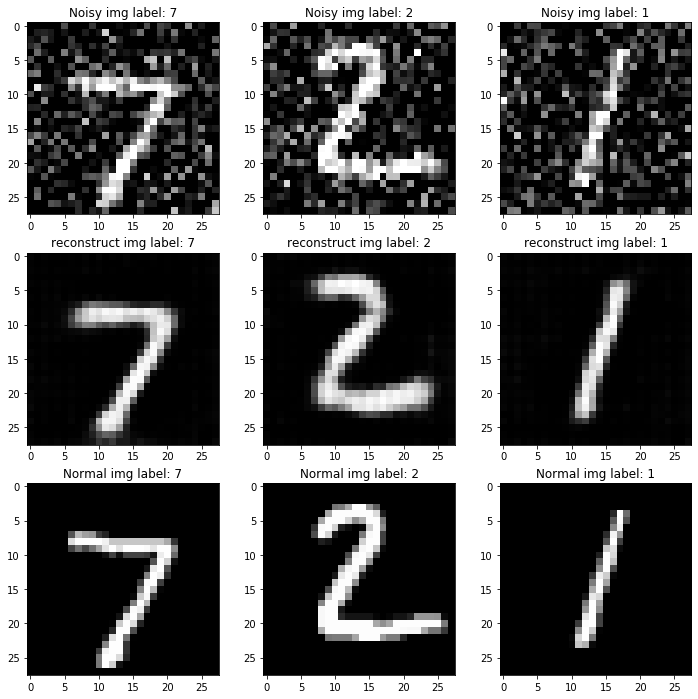

In [565]:
batch_idx, (images, _) = next(enumerate(test_loader))
images = images[0].to(device)
output = AE(images).cpu().detach()
images = images.cpu()

print(images.size(), output.size())

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)
#batch_idx, (images, _) = next(enumerate(test_loader))


for idx in range(3):
    ax[0,idx].imshow(images[idx][0], cmap='gray')
    ax[0,idx].set_title(f'Noisy img label: {_[1][idx]}')
    ax[1,idx].imshow(output[idx][0], cmap='gray')
    ax[1,idx].set_title(f'reconstruct img label: {_[1][idx]}')
    ax[2,idx].imshow(_[0][idx][0], cmap='gray')
    ax[2,idx].set_title(f'Normal img label: {_[1][idx]}')
fig.show()

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [4]:
###########################   <YOUR CODE>  ############################

import torchvision
import torch
import torch.optim as optim

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)


device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')
print(f'Device name {torch.cuda.get_device_name(0)}')
#########################  <END YOUR CODE>  ############################

We are using device name "cuda"
Device name NVIDIA GeForce GTX 1060 with Max-Q Design


In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 

batch_size_train, batch_size_test = 64, 1000

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [6]:
def vae_loss(output, mu, log_var, images):


  ###########################   <YOUR CODE>  ############################
    regu = 1 + log_var - mu.pow(2) - log_var.exp()
    regu_sum = -0.5 * torch.sum(regu)
    Loss_reco = F.binary_cross_entropy(input=output.view(-1, 28*28), target=images.view(-1, 28*28), reduction='sum')

    return Loss_reco, regu_sum

  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [7]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
    def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
        super(our_VAE, self).__init__()

        self.latent_feature = latent_feature

    
        self.en_input1 = nn.Linear(in_features=784, out_features=500)
        self.en_hidden1 = nn.Linear(in_features=500, out_features=latent_feature)

        self.en_hidden2 = nn.Linear(in_features=500, out_features=latent_feature)
        #    self.en_hidden2 = nn.Linear(in_features=500, out_features=latent_feature)

        self.de_hidden = nn.Linear(in_features=500, out_features=784)
        self.de_latent = nn.Linear(in_features=latent_feature, out_features=500)


    def reparameterize(self, mu, log_var):


        sample = torch.randn_like(torch.exp(log_var/2))*torch.exp(log_var/2) + mu # mean + std+E

        return sample
    def encoder(self, x):

        #forword
        x = x.view(-1, 784)
        
        x = self.en_input1(x)
        x = F.relu(x)
        
        mu = self.en_hidden1(x)
        log_var =  self.en_hidden2(x)

        z = self.reparameterize(mu,log_var)


        return mu, log_var, z

    def decoder(self, z):


        #forword
        z = self.de_latent(z)
        x = F.relu(z)
        
        x = torch.sigmoid((self.de_hidden(x)))
        return x


  
    def forward(self, x):



        mu = self.encoder(x)[0]
        log_var = self.encoder(x)[1]
        z = self.encoder(x)[2]
        #decode
        x = self.decoder(z)

    
        return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [8]:
###########################   <YOUR CODE>  ############################
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
learning_rate = 0.0001 
batch_size_train, batch_size_test = 64, 1000
epochs = 1

VAE = our_VAE().to(device)

optimizer = optim.Adam(params=VAE.parameters(), lr=learning_rate)

#########################  <END YOUR CODE>  ###########################


In [10]:
elbo_n = []
loss_rec = []
KL_loss = []
epochs = 29


for epoch in range(epochs):
    batch_count = 0
    for idx, (images,_) in enumerate(train_loader, 0):
        
        _ = _.to(device)
        images = images.to(device)
        
        
        reconstructions, mu, log_var = VAE(images)

        ReconstructionLoss, Regularizer = vae_loss(reconstructions, mu, log_var, images)
        loss = ReconstructionLoss + Regularizer

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        if (idx % 10) == 0:
            
            elbo_n.append(loss.item()/batch_size_train)
            loss_rec.append(ReconstructionLoss/batch_size_train)
            KL_loss.append(Regularizer/batch_size_train)


        if (idx % 100) == 0:
            print(f'Epoch {epoch+1}: [{idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


Epoch 1: [0/60000] Loss: 541.614990234375
Epoch 1: [6400/60000] Loss: 265.60626220703125
Epoch 1: [12800/60000] Loss: 224.97598266601562
Epoch 1: [19200/60000] Loss: 226.33551025390625
Epoch 1: [25600/60000] Loss: 208.12464904785156
Epoch 1: [32000/60000] Loss: 184.79495239257812
Epoch 1: [38400/60000] Loss: 180.6696319580078
Epoch 1: [44800/60000] Loss: 181.85986328125
Epoch 1: [51200/60000] Loss: 165.03297424316406
Epoch 1: [57600/60000] Loss: 165.04742431640625
Epoch 2: [0/60000] Loss: 169.83070373535156
Epoch 2: [6400/60000] Loss: 163.33038330078125
Epoch 2: [12800/60000] Loss: 150.0075225830078
Epoch 2: [19200/60000] Loss: 155.22032165527344
Epoch 2: [25600/60000] Loss: 159.76644897460938
Epoch 2: [32000/60000] Loss: 150.3697052001953
Epoch 2: [38400/60000] Loss: 142.97723388671875
Epoch 2: [44800/60000] Loss: 142.7040252685547
Epoch 2: [51200/60000] Loss: 139.32754516601562
Epoch 2: [57600/60000] Loss: 145.5557861328125
Epoch 3: [0/60000] Loss: 143.24835205078125
Epoch 3: [6400/6

Epoch 18: [12800/60000] Loss: 109.17564392089844
Epoch 18: [19200/60000] Loss: 107.81333923339844
Epoch 18: [25600/60000] Loss: 109.84882354736328
Epoch 18: [32000/60000] Loss: 114.83026885986328
Epoch 18: [38400/60000] Loss: 112.80632019042969
Epoch 18: [44800/60000] Loss: 105.24431610107422
Epoch 18: [51200/60000] Loss: 106.14044952392578
Epoch 18: [57600/60000] Loss: 106.5606918334961
Epoch 19: [0/60000] Loss: 106.93474578857422
Epoch 19: [6400/60000] Loss: 107.42587280273438
Epoch 19: [12800/60000] Loss: 110.96941375732422
Epoch 19: [19200/60000] Loss: 108.45460510253906
Epoch 19: [25600/60000] Loss: 108.63186645507812
Epoch 19: [32000/60000] Loss: 110.48668670654297
Epoch 19: [38400/60000] Loss: 113.35997772216797
Epoch 19: [44800/60000] Loss: 111.44552612304688
Epoch 19: [51200/60000] Loss: 108.90951538085938
Epoch 19: [57600/60000] Loss: 101.70510864257812
Epoch 20: [0/60000] Loss: 105.42315673828125
Epoch 20: [6400/60000] Loss: 101.85847473144531
Epoch 20: [12800/60000] Loss: 1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


our_VAE(
  (en_input1): Linear(in_features=784, out_features=500, bias=True)
  (en_hidden1): Linear(in_features=500, out_features=16, bias=True)
  (en_hidden2): Linear(in_features=500, out_features=16, bias=True)
  (de_hidden): Linear(in_features=500, out_features=784, bias=True)
  (de_latent): Linear(in_features=16, out_features=500, bias=True)
)

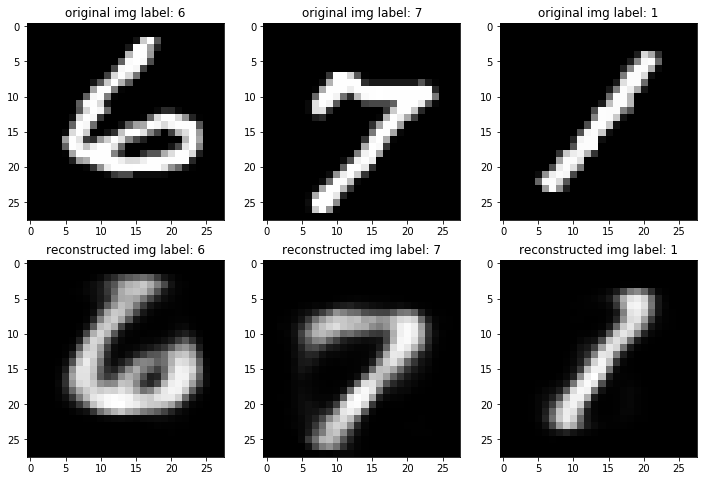

In [697]:
import random

with torch.no_grad():
    

    data = random.sample(list(test_loader), 1)
    for (images, label) in random.sample(list(test_loader), 1):
        images = images.to(device)
        images_0 = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        images_1 = np.transpose(imgs[1].cpu().numpy(), [1,2,0])
        images_2 = np.transpose(imgs[2].cpu().numpy(), [1,2,0])
        
        out0 = out[0]
        img1 = out0.cpu().reshape(28,28)
        out1 = out[1]
        img2 = out1.cpu().reshape(28,28)
        out2 = out[2]
        img3 = out2.cpu().reshape(28,28)

        #fig, ax = plt.subplots(2,3)
        #fig.set_size_inches(12,8)
        fig,ax = plt.subplots(2,3)
        fig.set_size_inches(12,8)
        

        ax[0,0].imshow(np.squeeze(img_1),cmap='gray')
        ax[0,0].set_title(f'original img label: {label[1]}')
        ax[1,0].imshow(img2, cmap='gray')
        ax[1,0].set_title(f'reconstructed img label: {label[1]}')    
        
        ax[0,1].imshow(np.squeeze(img_0),cmap='gray')
        ax[0,1].set_title(f'original img label: {label[0]}')
        ax[1,1].imshow(img1, cmap='gray')
        ax[1,1].set_title(f'reconstructed img label: {label[0]}')

        ax[0,2].imshow(np.squeeze(img_2),cmap='gray')
        ax[0,2].set_title(f'original img label: {label[2]}')
        ax[1,2].imshow(img3, cmap='gray')
        ax[1,2].set_title(f'reconstructed img label: {label[2]}')

    fig.show() 


i = 0
VAE.eval()

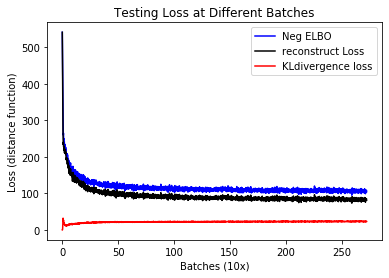

In [11]:
losses = plt.figure(2)
#fig, ax = plt.subplots(1,3)
#fig.set_size_inches(12,8)

plt.plot(np.arange(len(elbo_n))/10, elbo_n, 'b')
plt.plot(np.arange(len(loss_rec))/10, loss_rec,'k')
plt.plot(np.arange(len(KL_loss))/10, KL_loss,'r')

plt. title ('Testing Loss at Different Batches')
plt. ylabel ('Loss (distance function)')
plt.xlabel ('Batches (10x)')
legend1 = ['Neg ELBO', 'reconstruct Loss', 'KLdivergence loss']
plt. legend(legend1)


plt.show()



### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [681]:
def plot_latent(vae, data_loader, num_batches=2):
    with torch.no_grad():
        for ibx, (images,label) in enumerate(data_loader):
            _,_,z = vae.encoder(images.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
            if ibx > num_batches:
                break
    plt.colorbar()
    plt.show()

In [686]:
###########################   <YOUR CODE>  ############################
class our_VAE2(nn.Module):
    def __init__(self, latent_feature = 2): # you can use any number of latent features you want in the training
        super(our_VAE2, self).__init__()

        self.latent_feature = latent_feature

    # define the transformations for your encoder and decoder
    
        self.en_input1 = nn.Linear(in_features=784, out_features=500)
        self.en_hidden1 = nn.Linear(in_features=500, out_features=latent_feature)

        self.en_hidden2 = nn.Linear(in_features=500, out_features=latent_feature)
        #    self.en_hidden2 = nn.Linear(in_features=500, out_features=latent_feature)

        self.de_hidden = nn.Linear(in_features=500, out_features=784)
        self.de_latent = nn.Linear(in_features=latent_feature, out_features=500)


    def reparameterize(self, mu, log_var):


        sample = torch.randn_like(torch.exp(log_var/2))*torch.exp(log_var/2) + mu # mean + std+E

        return sample
    def encoder(self, x):

        #forword
        x = x.view(-1, 784)
        
        x = self.en_input1(x)
        x = F.relu(x)
        
        mu = self.en_hidden1(x)
        log_var =  self.en_hidden2(x)

        z = self.reparameterize(mu,log_var)


        return mu, log_var, z

    def decoder(self, z):


        #forword
        z = self.de_latent(z)
        x = F.relu(z)
        
        x = torch.sigmoid((self.de_hidden(x)))
        return x


  
    def forward(self, x):



        mu = self.encoder(x)[0]
        log_var = self.encoder(x)[1]
        z = self.encoder(x)[2]
        #decode
        x = self.decoder(z)

    
        return x, mu, log_var

In [687]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
learning_rate = 0.0001 
batch_size_train, batch_size_test = 64, 1000
epochs = 1

VAE = our_VAE2().to(device)
optimizer = optim.Adam(params=VAE.parameters(), lr=learning_rate)

In [688]:
def train(epoch, device):

    VAE.train()

    for batch_idx, (images, orig) in enumerate(train_loader):

        optimizer.zero_grad()
        images = images.to(device)
        orig = orig.to(device)
        output, mu, log_var = VAE(images)
        loss, KLD = vae_loss(output, mu, log_var, images) 
        elbo = loss + KLD
        elbo.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            train_elbo.append(elbo.item()/batch_size_train) 
            train_loss.append(loss.item()/batch_size_train)
            train_kld.append(KLD.item()/batch_size_train)
            train_idx.append(batch_idx / 10)
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        if batch_idx % 100 == 0: 
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {elbo.item()/batch_size_train}')


def test(epoch, device):

    VAE.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for images, orig in test_loader:
            #images = images.()
            images = images.to(device)
            orig = orig.to(device)
            output, mu, log_var = VAE(images)
            loss, kld = vae_loss(output, mu, log_var, images)
            elbo = loss + kld
            test_loss += elbo
  
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_counter.append(len(train_loader.dataset)*epoch)

    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')



Epoch 1: [0/60000] Loss: 189.12327575683594
Epoch 1: [6400/60000] Loss: 192.7493133544922
Epoch 1: [12800/60000] Loss: 181.10267639160156
Epoch 1: [19200/60000] Loss: 180.37586975097656
Epoch 1: [25600/60000] Loss: 172.41796875
Epoch 1: [32000/60000] Loss: 178.69703674316406
Epoch 1: [38400/60000] Loss: 175.95465087890625
Epoch 1: [44800/60000] Loss: 180.30374145507812
Epoch 1: [51200/60000] Loss: 179.25967407226562
Epoch 1: [57600/60000] Loss: 187.05014038085938
Test result on epoch 1: Avg loss is 177.90573120117188


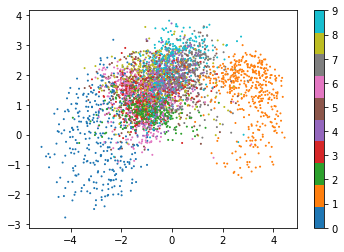

Epoch 2: [0/60000] Loss: 173.61524963378906
Epoch 2: [6400/60000] Loss: 174.3282928466797
Epoch 2: [12800/60000] Loss: 168.59487915039062
Epoch 2: [19200/60000] Loss: 181.24362182617188
Epoch 2: [25600/60000] Loss: 173.5217742919922
Epoch 2: [32000/60000] Loss: 167.50035095214844
Epoch 2: [38400/60000] Loss: 184.5255889892578
Epoch 2: [44800/60000] Loss: 180.3052978515625
Epoch 2: [51200/60000] Loss: 163.1604766845703
Epoch 2: [57600/60000] Loss: 175.9038543701172
Test result on epoch 2: Avg loss is 173.40492248535156


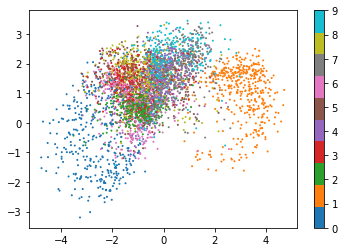

Epoch 3: [0/60000] Loss: 175.53697204589844
Epoch 3: [6400/60000] Loss: 179.00067138671875
Epoch 3: [12800/60000] Loss: 167.923095703125
Epoch 3: [19200/60000] Loss: 175.57994079589844
Epoch 3: [25600/60000] Loss: 174.5373992919922
Epoch 3: [32000/60000] Loss: 173.1880340576172
Epoch 3: [38400/60000] Loss: 165.46168518066406
Epoch 3: [44800/60000] Loss: 162.76651000976562
Epoch 3: [51200/60000] Loss: 179.62376403808594
Epoch 3: [57600/60000] Loss: 165.0283660888672
Test result on epoch 3: Avg loss is 169.83641052246094


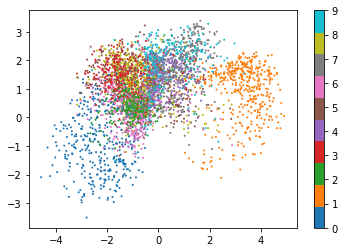

Epoch 4: [0/60000] Loss: 166.2953643798828
Epoch 4: [6400/60000] Loss: 166.9381561279297
Epoch 4: [12800/60000] Loss: 183.5512237548828
Epoch 4: [19200/60000] Loss: 158.77493286132812
Epoch 4: [25600/60000] Loss: 168.7210693359375
Epoch 4: [32000/60000] Loss: 170.55355834960938
Epoch 4: [38400/60000] Loss: 164.44509887695312
Epoch 4: [44800/60000] Loss: 172.88674926757812
Epoch 4: [51200/60000] Loss: 168.10557556152344
Epoch 4: [57600/60000] Loss: 175.9656982421875
Test result on epoch 4: Avg loss is 167.33584594726562


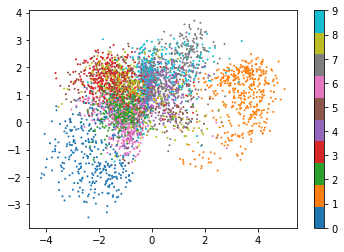

Epoch 5: [0/60000] Loss: 167.12722778320312
Epoch 5: [6400/60000] Loss: 170.23292541503906
Epoch 5: [12800/60000] Loss: 164.02008056640625
Epoch 5: [19200/60000] Loss: 167.38327026367188
Epoch 5: [25600/60000] Loss: 170.22686767578125
Epoch 5: [32000/60000] Loss: 175.78538513183594
Epoch 5: [38400/60000] Loss: 176.09080505371094
Epoch 5: [44800/60000] Loss: 168.09059143066406
Epoch 5: [51200/60000] Loss: 167.8831329345703
Epoch 5: [57600/60000] Loss: 178.12615966796875
Test result on epoch 5: Avg loss is 165.49884033203125


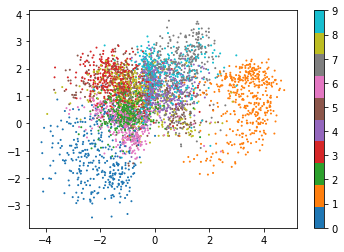

In [691]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
train_elbo = []
train_loss = []
train_kld = []
train_idx = []
train_counter = []

max_epoch = 5
for epoch in range(1, max_epoch+1):
    train(epoch, device=device)
    test(epoch, device=device)
    plot_latent(VAE, test_loader, num_batches=2)

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

In [ ]:
###########################   <YOUR CODE>  ############################

#########################  <END YOUR CODE>  ###########################